# Machine Learning for Medicine TP 3
## Gaussian Mixture Models and the Expectation-Maximization Algorithm

In [1]:
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn import mixture
import random

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score
import os
import pandas as pd
import numpy as np

from scipy.stats import norm, multivariate_normal
from sklearn.decomposition import PCA


data_dir = 'data'

In [2]:
import matplotlib.pyplot as plt

### 1D simulated data

In [3]:
mu1, sigma1 = 0, 0.3 # mean and standard deviation
s1 = np.random.normal(mu1, sigma1, 100)
y1 = np.repeat(0, 100)

mu2, sigma2 = 2, 0.3 # mean and standard deviation
s2 = np.random.normal(mu2, sigma2, 100)
y2 = np.repeat(1, 100)

mu = [mu1, mu2]
sigma = [sigma1, sigma2]
data_1d = np.concatenate([s1,s2])
y_1d = np.concatenate([y1,y2])


In [4]:
plt.hist(data_1d, 50)
plt.show()

In [5]:
def pr_single_comp(mu, sigma, x):
    prob = []
    for i in range(0, x.shape[0]):
        prob.append(np.exp(-0.5*((x[i,]-mu)/sigma)**2)/sigma)
    return prob 

def pr_single_normalized(mu,sigma, x):
    unnorm_prob = pr_single_comp(mu, sigma, x)
    normalization = np.sum(unnorm_prob, axis=1)
    prob = []
    for i in range(0, len(unnorm_prob)) :
        prob.append(unnorm_prob[:][i]/normalization[i])
#         prob[-1][np.isnan(prob[-1])] = 0
    return prob

def update_mu(x,mu,sigma) :
    prob = pr_single_normalized(mu,sigma,x)
    hat_mu = [0, 0]
    for i in range(0, len(prob)) :
        hat_mu = hat_mu + prob[i][:]*x[i,]
    hat_mu = hat_mu/np.sum(prob, axis=0)
    return hat_mu

def update_sigma(x,mu,sigma) :
    prob = pr_single_normalized(mu,sigma,x)
    hat_sigma = [0, 0]
    for i in range(0, len(prob)) :
        hat_sigma = hat_sigma + prob[i][:]*(x[i,] - mu)**2
    hat_sigma = hat_sigma/np.sum(prob, axis=0)
    return hat_sigma


In [9]:
mu_old = [random.uniform(-2, 2), random.uniform(0, 4)]
# mu_old = [random.uniform(-.5, .5), random.uniform(1.5, 2.5)]
sigma_old = [0.3, 0.3]
# sigma_old = np.array([1, 1])
NbIter = 10

data, labels = data_1d, y_1d

print('init\nmu = {}\nsigma = {}\n'.format(mu_old, sigma_old))
# Learning procedure (optimization)
for iter in range(1, NbIter):
    hat_mu = update_mu(data,mu_old,sigma_old)
    hat_sigma = update_sigma(data,mu_old,sigma_old)
    print('iter', iter)
    print('updated mu = ',hat_mu)
    print('updated sigma = ',hat_sigma)
    mu_old = hat_mu
    sigma_old = hat_sigma + 1e-13
    

init
mu = [1.2904462352595618, 0.6352131729388466]
sigma = [0.3, 0.3]

iter 1
updated mu =  [ 2.02061368 -0.02790655]
updated sigma =  [0.62821727 0.52503432]
iter 2
updated mu =  [ 2.00866894 -0.02929811]
updated sigma =  [0.11568824 0.08631267]
iter 3
updated mu =  [ 2.02736385 -0.03023164]
updated sigma =  [0.08342949 0.0786795 ]
iter 4
updated mu =  [ 2.02736385 -0.03023164]
updated sigma =  [0.08307999 0.07867863]
iter 5
updated mu =  [ 2.02736385 -0.03023164]
updated sigma =  [0.08307999 0.07867863]
iter 6
updated mu =  [ 2.02736385 -0.03023164]
updated sigma =  [0.08307999 0.07867863]
iter 7
updated mu =  [ 2.02736385 -0.03023164]
updated sigma =  [0.08307999 0.07867863]
iter 8
updated mu =  [ 2.02736385 -0.03023164]
updated sigma =  [0.08307999 0.07867863]
iter 9
updated mu =  [ 2.02736385 -0.03023164]
updated sigma =  [0.08307999 0.07867863]


###  2D simulated data

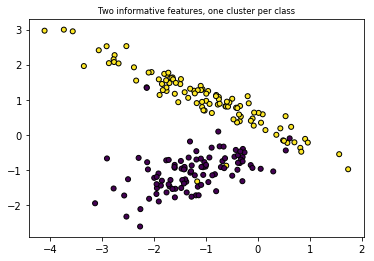

In [155]:
# First simulated 2D data set
plt.title("Two informative features, one cluster per class", fontsize='small')
X1, Y1 = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2,
n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,s=25, edgecolor='k')

In [179]:
# Second simulated 2D data set
plt.title("Three blobs", fontsize='small')
X2, Y2 = make_blobs(n_samples=200, n_features=2, centers=3)
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2, s=25, edgecolor='k')

In [137]:
# Third simulated 2D data set
plt.title("Non-linearly separated data sets", fontsize='small')
X3, Y3 = make_moons(n_samples=200, shuffle=True, noise=None, random_state=None)
plt.scatter(X3[:, 0], X3[:, 1], marker='o', c=Y3, s=25, edgecolor='k')

In [257]:
# EM for nD

def pr_multi_normalized(mu,sigma, x):
    unnorm_prob = np.stack([multivariate_normal.pdf(x, mean=m, cov=s) for m,s in zip(mu, sigma)], axis=-1)
    normalization = np.sum(unnorm_prob, axis=1, keepdims=True)
    prob = unnorm_prob/normalization
    return prob

def update_mu_multi(x,mu,sigma) :
    prob = pr_multi_normalized(mu,sigma,x)
    prob = np.expand_dims(prob, 2)
    hat_mu = np.sum(np.expand_dims(x,1) * prob, axis=0) / np.sum(prob, axis=0)
    return hat_mu

def update_sigma_multi(x,mu,sigma) :
    prob = pr_multi_normalized(mu,sigma,x)
    hat_sigma = np.stack([np.cov(x.T, aweights=prob[:,i]) for i in range(len(sigma))], axis=0)
    return hat_sigma


def em_multi(NbIter, mu_old, sigma_old, data, labels, k):
    print(' -- init --\nmu = {}\nsigma = {}\n'.format(mu_old, sigma_old))
    # Learning procedure (optimization)
    for iter in range(1, NbIter):
        hat_mu = update_mu_multi(data,mu_old,sigma_old)
        hat_sigma = update_sigma_multi(data,mu_old,sigma_old)
        print('iter', iter)
        print('updated mu = ',hat_mu)
        print('updated sigma = ',hat_sigma)
        mu_old = hat_mu
        sigma_old = hat_sigma + 1e-13
        
    mu = np.stack([np.mean(data[label==i], axis=0) for i in range(k)])
    sig = np.stack([np.cov(data[label==i].T) for i in range(k)])
    print('\n -- true val -- \nmu={}\nsigma={}'.format(mu, sig))

    
u = random.uniform


In [293]:
#first dataset
k=2

NbIter = 10

mu_old = np.array([[u(-2,0),u(0,2)], [u(-2,0), u(-2,0)]])
sigma_old = np.tile(np.eye(2), (k,1,1))

em_multi(NbIter, mu_old=mu_old, sigma_old=sigma_old, data=X1, labels=Y1, k=k)

 -- init --
mu = [[-0.83175315  0.72968316]
 [-0.15226699 -0.33014308]]
sigma = [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]

iter 1
updated mu =  [[-1.38632432  0.60567352]
 [-0.87271512 -0.64374949]]
updated sigma =  [[[ 0.91956732 -0.44829929]
  [-0.44829929  1.51267063]]

 [[ 0.86340393  0.32282657]
  [ 0.32282657  0.80406717]]]
iter 2
updated mu =  [[-1.36166536  0.78063417]
 [-0.92676063 -0.72618434]]
updated sigma =  [[[ 0.95299842 -0.62546429]
  [-0.62546429  1.32178654]]

 [[ 0.87354924  0.44231654]
  [ 0.44231654  0.68386719]]]
iter 3
updated mu =  [[-1.27938991  0.93240991]
 [-1.00541927 -0.84010201]]
updated sigma =  [[[ 1.05178784 -0.7353187 ]
  [-0.7353187   1.02016998]]

 [[ 0.84275325  0.44400875]
  [ 0.44400875  0.55025128]]]
iter 4
updated mu =  [[-1.17979783  1.03337717]
 [-1.09285125 -0.94471379]]
updated sigma =  [[[ 1.18233473 -0.81433208]
  [-0.81433208  0.76327264]]

 [[ 0.75742199  0.37446547]
  [ 0.37446547  0.40906278]]]
iter 5
updated mu =  [[-1.11099086  1.0

In [294]:
#second dataset

k=3
NbIter = 10

mu_old = np.array([[u(-7,-3),u(5,9)], [u(0,4), u(5,9)], [u(7,10), u(5,9)]])
sigma_old = np.tile(np.eye(2), (k,1,1))

em_multi(NbIter, mu_old=mu_old, sigma_old=sigma_old, data=X2, labels=Y2, k=k)

 -- init --
mu = [[-6.39187017  7.20355146]
 [ 3.12560033  5.07844879]
 [ 7.15125664  6.82279087]]
sigma = [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]

iter 1
updated mu =  [[-4.77354924  6.32476991]
 [ 1.78448811  5.16362398]
 [ 8.76759675  8.27543576]]
updated sigma =  [[[ 1.07560233 -0.14437659]
  [-0.14437659  0.85806995]]

 [[ 0.86963049  0.06540706]
  [ 0.06540706  1.03408405]]

 [[ 0.87367915  0.0027073 ]
  [ 0.0027073   0.99245198]]]
iter 2
updated mu =  [[-4.76451477  6.32207983]
 [ 1.79212861  5.16344317]
 [ 8.76796007  8.27561612]]
updated sigma =  [[[ 1.10606391 -0.15398634]
  [-0.15398634  0.85892483]]

 [[ 0.84931328  0.06642431]
  [ 0.06642431  1.03653951]]

 [[ 0.87181648  0.00176581]
  [ 0.00176581  0.99204191]]]
iter 3
updated mu =  [[-4.76174148  6.32123089]
 [ 1.79436996  5.16341366]
 [ 8.76796007  8.27561612]]
updated sigma =  [[[ 1.11551992 -0.15702744]
  [-0.15702744  0.85923189]]

 [[ 0.84335962  0.06657175]
  [ 0.06657175  1.03733606]]

 [

In [252]:
#third dataset

k=2
NbIter = 10

mu_old = np.array([[u(0,1),u(0,1)], [u(0,1), u(0,1)],])
sigma_old = np.tile(np.eye(2), (k,1,1))

em_multi(NbIter, mu_old=mu_old, sigma_old=sigma_old, data=X3, labels=Y3, k=k)

 -- true val -- 
mu=[[0.61944612 0.18749556]
 [0.46942532 0.23559726]]
sigma=[[[ 0.76811911 -0.23365194]
  [-0.23365194  0.26207679]]

 [[ 0.66435952 -0.14156011]
  [-0.14156011  0.23051677]]]

 -- init --
mu = [[0.13682784 0.30769443]
 [0.6929681  0.83497908]]
sigma = [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]

iter 1
updated mu =  [[0.35545421 0.23974697]
 [0.66244769 0.26152286]]
updated sigma =  [[[ 0.73591978 -0.19291562]
  [-0.19291562  0.24392176]]

 [[ 0.73472311 -0.1926104 ]
  [-0.1926104   0.24313749]]]
iter 2
updated mu =  [[0.3470591  0.23885667]
 [0.65372853 0.26120072]]
updated sigma =  [[[ 0.73546717 -0.19281411]
  [-0.19281411  0.24362939]]

 [[ 0.73518546 -0.19282555]
  [-0.19282555  0.24346226]]]
iter 3
updated mu =  [[0.34683844 0.23854378]
 [0.6531981  0.26145895]]
updated sigma =  [[[ 0.73542855 -0.19284031]
  [-0.19284031  0.2435466 ]]

 [[ 0.73532039 -0.19288394]
  [-0.19288394  0.24353264]]]
iter 4
updated mu =  [[0.34697794 0.23825026]
 [0.65302421 0.2617499 ]

> On observe de bons résultats sur les deux premiers datasets car ils sont issus de gaussiennes, selon l'initialisation l'algo EM permet de retrouver les mu et sigma.
Mais des résultats très pauvres sur le troisième qui est généré à partir de demi-lunes, l'algo EM avec mélange de gaussiennes a peu de sens sur ce type de donnée.

### With scipy's GaussianMixure module


In [296]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

#### Artificial 2D data

In [312]:
def find_num_clusters(X, n_list, ):
    lowest_bic = np.infty
    bic = []
    best_k = -1
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_list:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                best_k = n_components
                lowest_bic = bic[-1]
                best_gmm = gmm

#     y_predicted = best_gmm.predict(X)
    print("num clusters : ", best_k)
    return best_gmm, best_k


num clusters :  2
mu =  [[-1.0459498   1.0576383 ]
 [-1.22151087 -1.06679804]]
sigma =  [[[ 1.34306422 -0.85535908]
  [-0.85535908  0.59843574]]

 [[ 0.54838177  0.20648461]
  [ 0.20648461  0.24051426]]]


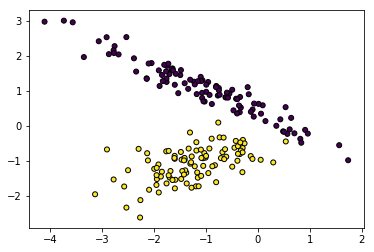

In [323]:
# first artificial dataset :
data = X1

gmm, k = find_num_clusters(data, [1,2,3,4, 10, 20])

print('mu = ', gmm.means_)
print('sigma = ', gmm.covariances_)
plt.scatter(data[:, 0], data[:, 1], marker='o', c=gmm.predict(data),s=25, edgecolor='k')
plt.show()

num clusters :  3
mu =  [[-4.77147758  6.32416461]
 [ 8.76796006  8.27561612]
 [ 1.78637038  5.16359273]]
sigma =  [[ 0.92607464 -0.02643127]
 [-0.02643127  0.94682329]]


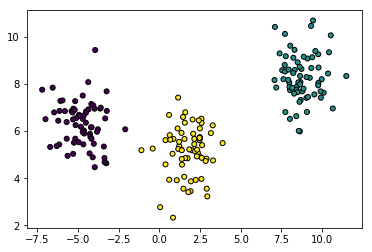

In [324]:
# second artificial dataset :
data = X2

gmm, k = find_num_clusters(data, [1,2,3,4, 10, 20])

print('mu = ', gmm.means_)
print('sigma = ', gmm.covariances_)
plt.scatter(data[:, 0], data[:, 1], marker='o', c=gmm.predict(data),s=25, edgecolor='k')
plt.show()

In [322]:
# third artificial dataset :
data = X3

gmm, k = find_num_clusters(data, [1,2,3,])

print('mu = ', gmm.means_)
print('sigma = ', gmm.covariances_)
plt.scatter(data[:, 0], data[:, 1], marker='o', c=gmm.predict(data),s=25, edgecolor='k')
plt.show()

num clusters :  3
mu =  [[ 1.81578052  0.01486405]
 [-0.82019119  0.48015046]
 [ 0.49687059  0.25206506]]
sigma =  [[[ 0.02739841  0.04193873]
  [ 0.04193873  0.07174885]]

 [[ 0.02612928  0.04065845]
  [ 0.04065845  0.07061467]]

 [[ 0.22549467 -0.15060861]
  [-0.15060861  0.30384724]]]


> On constate que `GaussianMixture()` permet de bien retrouver le nombre de clusters sur les datasets 1 et 2 mais pas suer le 3 qui n'est pas un mélange de gaussienes

#### Mice and Breast Cancer datasets

In [362]:
from itertools import permutations
from sklearn.metrics import accuracy_score

def best_perm(true_labels, pred_labels, num_labels):
    best_acc = 0
    for perm in permutations(range(num_labels)):
        print('perm: ', perm)
        f = lambda x: perm[x]
        acc = accuracy_score(true_labels, np.vectorize(f)(pred_labels))
        if acc > best_acc:
            best_acc = acc
    return best_acc

In [363]:
## Breast Cancer Wisconsin (Diagnostic) Data Set
wdbc_ds = pd.read_csv(os.path.join(data_dir, 'wdbc.data'))
#'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal dimension']
features = ['feature{}'.format(i) for i in range(30)]
columns = ['ID_number', 'Diagnosis']+features 
wdbc_ds.columns = columns
wdbc_ds.Diagnosis = wdbc_ds.Diagnosis.astype('category').cat.codes
wdbc_ds = wdbc_ds.set_index('ID_number')
Y4 = wdbc_ds.Diagnosis
X4 = wdbc_ds[features]

X4_pca = PCA(n_components=2).fit_transform(X4)
plt.scatter(X4_pca[:, 0], X4_pca[:, 1], s=10, c=Y4)
plt.show()

# print(wdbc_ds.Diagnosis)
# wdbc_ds

num clusters :  2
mu =  [[1.21644185e+01 1.81164500e+01 7.81902047e+01 4.64275229e+02
  9.26840912e-02 7.95927210e-02 4.67196189e-02 2.61675726e-02
  1.74223357e-01 6.27236834e-02 2.89414154e-01 1.23960479e+00
  2.02803595e+00 2.16789403e+01 7.30022619e-03 2.12308758e-02
  2.61658363e-02 1.00334471e-02 2.05669185e-02 3.60640348e-03
  1.34078445e+01 2.38243820e+01 8.71277217e+01 5.61732856e+02
  1.25317879e-01 1.79712201e-01 1.65603005e-01 7.50356247e-02
  2.69695508e-01 7.90014055e-02]
 [1.76012954e+01 2.14209380e+01 1.16337398e+02 9.92390171e+02
  1.02794160e-01 1.47532339e-01 1.62645562e-01 8.89248109e-02
  1.93211618e-01 6.28512942e-02 6.07785991e-01 1.17789227e+00
  4.32930505e+00 7.29857094e+01 6.58279346e-03 3.29207854e-02
  4.19795444e-02 1.49128842e-02 2.04520606e-02 4.11860271e-03
  2.13163308e+01 2.90151753e+01 1.42710026e+02 1.44240197e+03
  1.44769265e-01 3.84917943e-01 4.59704153e-01 1.84283651e-01
  3.25509603e-01 9.25732824e-02]]
sigma =  [[[ 3.10536325e+00  3.35202291e-

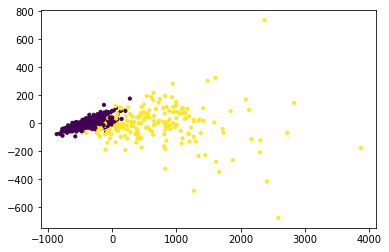

perm:  (0, 1)
perm:  (1, 0)
precision =  0.9507042253521126


In [364]:
# Breast Cancer :
data, labels = X4, Y4

gmm, k = find_num_clusters(data, [1,2,3,4])

print('mu = ', gmm.means_)
print('sigma = ', gmm.covariances_)
labels_pred = gmm.predict(data)
data_pca = PCA(n_components=2).fit_transform(data)
plt.scatter(data_pca[:, 0], data_pca[:, 1], s=10, c=labels_pred)
plt.show()

print('precision = ', best_perm(labels, labels_pred, k))

MouseID
309_1       c-CS-m
309_2       c-CS-m
309_3       c-CS-m
309_4       c-CS-m
309_5       c-CS-m
             ...  
J3295_11    t-SC-s
J3295_12    t-SC-s
J3295_13    t-SC-s
J3295_14    t-SC-s
J3295_15    t-SC-s
Name: class, Length: 1080, dtype: category
Categories (8, object): [c-CS-m, c-CS-s, c-SC-m, c-SC-s, t-CS-m, t-CS-s, t-SC-m, t-SC-s]


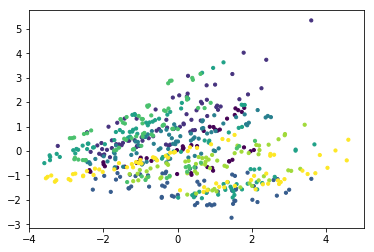

In [369]:
### Mice Protein Expression Data Set 
mice_ds = pd.read_excel(os.path.join(data_dir, "Data_Cortex_Nuclear.xls"))
mice_ds = mice_ds.set_index("MouseID")
# mice_ds.Genotype  = mice_ds.Genotype .astype('category').cat.codes
# mice_ds.Treatment = mice_ds.Treatment.astype('category').cat.codes
# mice_ds.Behavior  = mice_ds.Behavior .astype('category').cat.codes
mice_ds['class']  = mice_ds['class'] .astype('category')
print(mice_ds['class'])

# remove all nan :
mice_ds = mice_ds[~mice_ds.isna().any(axis=1)]

Y5 = mice_ds['class'].cat.codes.astype('float')
X5 = mice_ds[mice_ds.columns[:-4]]#.astype('float')

X5_pca = PCA(n_components=2).fit_transform(X5)
plt.scatter(X5_pca[:, 0], X5_pca[:, 1], s=10, c=Y5)
plt.show()

# print(Y5)
# mice_ds

num clusters :  10
mu =  [[0.29645482 0.49244127 0.29574683 2.21044066 3.38383922 0.23164905
  0.18042009 3.53277904 0.20379116 1.40470931 0.33164464 0.29876721
  0.28214    0.26650542 0.8150465  0.7354689  1.53749103 1.07531757
  0.41965039 0.74078364 0.27154605 0.3662366  0.1756553  1.10765645
  2.13800532 0.98783675 0.22702859 0.25493204 0.610218   0.16397226
  0.38302167 1.9942805  0.84408741 0.48814157 0.4937892  0.81196101
  0.5940009  0.374234   0.59853933 0.31449392 0.32313572 0.42102802
  0.39332402 0.16060037 0.88390668 0.14212294 1.32084811 0.25409828
  0.34439422 1.05426241 0.26732476 0.16649221 0.17151893 0.13145044
  0.16123029 0.1871291  0.22789972 0.11330315 0.21010683 0.11253956
  0.60443216 0.28350011 1.50375852 2.19081362 0.17637911 1.28000669
  0.80504539 0.24999052 0.15387699 0.13672014 0.13145044 0.13991093
  0.41872353 0.20651752 0.19975757 0.22139968 1.05877568]
 [0.69273644 0.90624902 0.3313914  2.36292325 3.81563556 0.20103301
  0.16622852 2.28523548 0.2099495

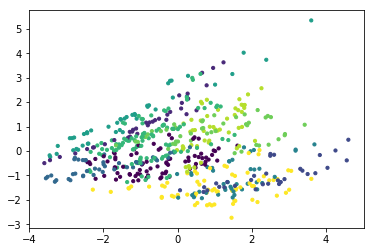

In [367]:
# Mice :
data, labels = X5, Y5

gmm, k = find_num_clusters(data, [1,2,3,4, 6, 7, 8, 9, 10])

print('mu = ', gmm.means_)
print('sigma = ', gmm.covariances_)
labels_pred = gmm.predict(data)
data_pca = PCA(n_components=2).fit_transform(data)
plt.scatter(data_pca[:, 0], data_pca[:, 1], s=10, c=labels_pred)
plt.show()

# print('precision = ', best_perm(labels, labels_pred, k))

> On observe que sur le breast cancer dataset, le critère BIC a permis de retrouver le nombre de classes (cad 2) et que les résultats sont très satisfaisants. La précision de classification de `GaussianMixture()` est de 95%.
En revanche sur le mice dataset le critère BIC a prédit 7 classes au lieu des 8.